In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
from modules.numeric import *
from scipy import signal, interpolate as interp
from scipy.optimize import curve_fit
from pathlib import Path
from functools import partial
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import r2_score

In [3]:
import matplotlib.pyplot as plt
from string import ascii_lowercase
from matplotlib import colors
from matplotlib.cm import ScalarMappable
from matplotlib.animation import PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rc('text', usetex=True)

In [4]:
from celluloid import Camera
from IPython.display import HTML

In [5]:
from multiprocessing import Pool, Value
from os import cpu_count

$$
\psi_{-}(x) = e^{-\kappa_{-} x}\left(3\tanh^{2}\left(\chi-x\right)+\kappa_{-}^{2}-1+3\kappa_{-}\tanh\left(\chi-x\right)\right)
$$

$$
\kappa_{-} = -\frac{3}{2}H-\sqrt{1-\frac{3}{4}H^{2}}
$$

In [6]:
phi4 = Phi4()
X0 = 17

def phi_dirichlet(x, H, mu=1):
    nu = np.sign(1 - abs(H))
    return mu*np.tanh(mu*np.arctanh(H**nu) - x)**nu

def psi_minus(x, H):
    kappa = -3*H/2 - sqrt(1 - 3*H**2/4)
    chi = np.arctanh(H)
    return np.exp(-kappa*x)*(3*np.tanh(chi - x)**2 + kappa**2 - 1 + 3*kappa*np.tanh(chi - x))

def phi_perturbed(x, A, H):
    return phi_dirichlet(x, H, mu=-1) + A*psi_minus(x, H)

def init(x, A, H):
    return np.stack((
        phi_perturbed(x - X0, A, H) + phi_perturbed(-x - X0, A, H) + 1,
        np.zeros(x.shape)
    ))

In [7]:
L = 100
N = 1024
DX = 2*X0/(N - 1)
DT = 4e-2

In [8]:
DX

0.033235581622678395

In [9]:
dirichlet = Dirichlet(order=4)

collider = Wave(
    x_grid= (-X0, X0, N), 
    dt= DT, 
    order= 4,
    y0= init,
    F= phi4.diff,
    boundaries= (dirichlet, dirichlet),
    integrator= 'rk4',
)

def run(A, H, t_final=None, **kwargs):
    if t_final == None: t_final = 100
    dirichlet.param = H
    grid, Y = collider.run(t_final, A=A, H=H, **kwargs)
    y, dydt = Y[:, 0], Y[:, 1]
    return grid, y, dydt

def plot(grid, y, ax=None, aspect='auto'):
    if ax == None: ax = plt.gca()
    return ax.imshow(y.T, cmap='turbo', vmin=-1.25, vmax=1.25, extent=grid.extent(), aspect=aspect, origin='lower', interpolation='sinc')

def run_and_plot(A, H, t_final=None, ax=None, aspect='auto', im=False, **kwargs):
    grid, y, dydt = run(A=A, H=H, t_final=t_final, **kwargs)
    img = plot(grid=grid, y=y, ax=ax, aspect=aspect)
    default_return = (grid, y, dydt)
    if im:
        return (*default_return, img)
    else:
        return default_return

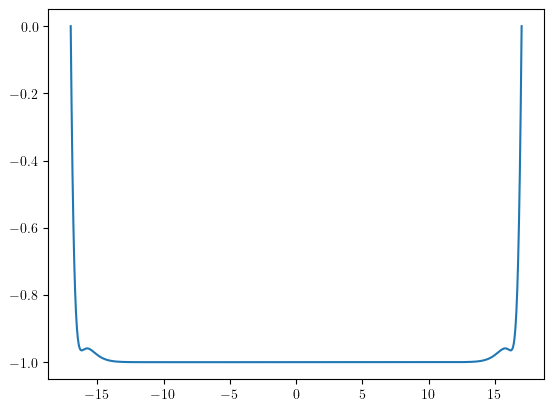

In [10]:
H = 0
# plt.plot(collider.x, phi_dirichlet(collider.x, H, -1))
plt.plot(collider.x, init(collider.x, 1, H)[0])
# plt.xlim(-5, 0)

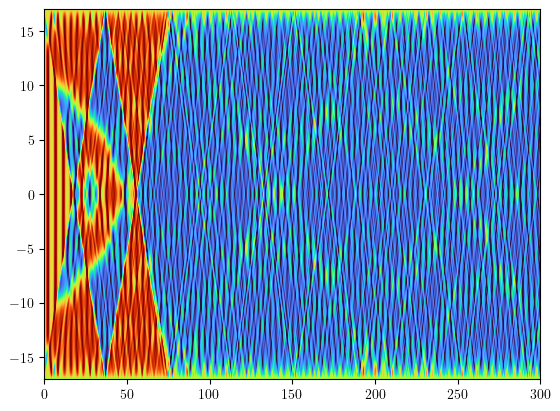

In [17]:
_, y ,_ = run_and_plot(0.4, -0.57, t_final=300)

(-10.0, -9.0)

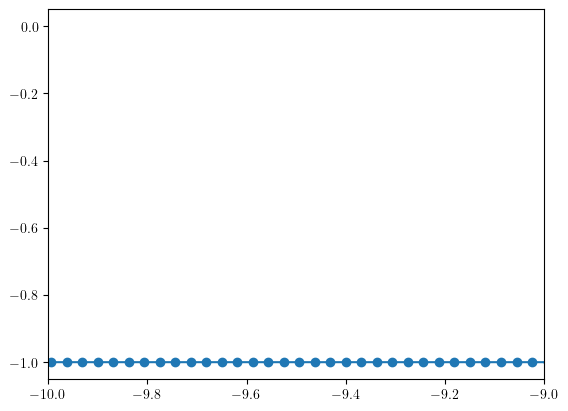

In [212]:
plt.plot(collider.x, y[4], '-o')
plt.xlim(-10, -9)